# EDF READER

In [1]:
import re, datetime, operator, logging
import numpy as np
from collections import namedtuple
import h5py
import random

In [2]:
EVENT_CHANNEL = 'EDF Annotations' #This defines a constant variable (EVENT_CHANNEL) with the string value 'EDF Annotations'.
log = logging.getLogger(__name__) # Creates (or retrieves) a logger with the name of the current module (__name__).

In [3]:
class EDFEndOfData: pass # used to signal when the end of an EDF (European Data Format) file is reached during reading/processing, pass means it inherits all behavior from Exception
WINDOW_SIZE = 100 # Defines a constant (WINDOW_SIZE) set to 100, typically representing: The number of samples or time points to process at once (e.g., in signal processing). A buffer size for reading chunks of data from an EDF file.

In [4]:
def rescale_array(X): # Adjusts values in an array to a smaller range and limits extreme values.
    X = X / 20
    X = np.clip(X, -5, 5)
    return X


def aug_X(X): # Adds small random changes to data to create variation (helpful for training AI models).
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False): # Generates endless batches of windowed data for training AI models.
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)
            X = rescale_array(X)

            yield X, Y


def chunker(seq, size=WINDOW_SIZE): # Splits a sequence (like a list or array) into smaller chunks.
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def tal(tal_str): # Parses a special string format (like timestamps with annotations).
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
        '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
        '(\x14(?P<annotation>[^\x00]*))?' + \
        '(?:\x14\x00)'

  def annotation_to_list(annotation):
    # print('annotatn:',annotation)
    return str(annotation).split('\x14') if annotation else []

  def parse(dic):
    return (
    float(dic['onset']), float(dic['duration']) if dic['duration'] else 0., annotation_to_list(dic['annotation']))

  return [parse(m.groupdict()) for m in re.finditer(exp, tal_str)]

def edf_header(f): #This function parses the header of an EDF (European Data Format) file, extracting metadata like patient information, recording details, channel configurations, and timestamps.
    h = {}
    assert f.tell() == 0  # check file position
    assert f.read(8) == '0       '
    # recording info)
    h['local_subject_id'] = f.read(80).strip()
    h['local_recording_id'] = f.read(80).strip()
    # parse timestamp
    (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    (hour, minute, sec) = [int(x) for x in re.findall('(\d+)', f.read(8))]
    h['date_time'] = str(datetime(year + 2000, month, day, hour, minute, sec))
    # misc
    header_nbytes = int(f.read(8))
    subtype = f.read(44)[:5]
    h['EDF+'] = subtype in ['EDF+C', 'EDF+D']
    h['contiguous'] = subtype != 'EDF+D'
    h['n_records'] = int(f.read(8))
    h['record_length'] = float(f.read(8))  # in seconds
    nchannels = h['n_channels'] = int(f.read(4))
    # read channel info
    channels = range(h['n_channels'])
    h['label'] = [f.read(16).strip() for n in channels]
    h['transducer_type'] = [f.read(80).strip() for n in channels]
    h['units'] = [f.read(8).strip() for n in channels]
    h['physical_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['physical_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_min'] = np.asarray([float(f.read(8)) for n in channels])
    h['digital_max'] = np.asarray([float(f.read(8)) for n in channels])
    h['prefiltering'] = [f.read(80).strip() for n in channels]
    h['n_samples_per_record'] = [int(f.read(8)) for n in channels]
    f.read(32 * nchannels)  # reserved
    assert f.tell() == header_nbytes
    return h

<>:41: SyntaxWarning: invalid escape sequence '\-'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:64: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
<>:41: SyntaxWarning: invalid escape sequence '\-'
<>:42: SyntaxWarning: invalid escape sequence '\d'
<>:64: SyntaxWarning: invalid escape sequence '\d'
<>:65: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saif\AppData\Local\Temp\ipykernel_4868\1063671403.py:41: SyntaxWarning: invalid escape sequence '\-'
  exp = '(?P<onset>[+\-]\d+(?:\.\d*)?)' + \
C:\Users\saif\AppData\Local\Temp\ipykernel_4868\1063671403.py:42: SyntaxWarning: invalid escape sequence '\d'
  '(?:\x15(?P<duration>\d+(?:\.\d*)?))?' + \
C:\Users\saif\AppData\Local\Temp\ipykernel_4868\1063671403.py:64: SyntaxWarning: invalid escape sequence '\d'
  (day, month, year) = [int(x) for x in re.findall('(\d+)', f.read(8))]
C:\Users\saif\AppData\Local\Temp\ipykernel_4868\1063671403.py:65: SyntaxWarning: invalid escape seque

In [5]:
class BaseEDFReader:
  def __init__(self, file, verbose=False):
    self.file = file
    self.verbose = verbose

  def read_header(self):
    if self.verbose:
        print('read_header')
    self.header = h = edf_header(self.file)
    # calculate ranges for rescaling
    self.dig_min = h['digital_min']
    self.phys_min = h['physical_min']
    phys_range = h['physical_max'] - h['physical_min']
    dig_range = h['digital_max'] - h['digital_min']
    assert np.all(phys_range > 0)
    assert np.all(dig_range > 0)
    self.gain = phys_range / dig_range

  def read_raw_record(self):
    if self.verbose:
        print('read raw record')
    # Read a record with data and return a list containing arrays with raw bytes.
    result = []
    for nsamp in self.header['n_samples_per_record']:
      samples = self.file.read(nsamp * 2)
      if len(samples) != nsamp * 2:
        raise EDFEndOfData
      result.append(samples)
    return result

  def convert_record(self, raw_record):
    if self.verbose:
        print('convert record')
    # Convert a raw record to a (time, signals, events) tuple based on information in the header.
    h = self.header
    dig_min, phys_min, gain = self.dig_min, self.phys_min, self.gain
    time = float('nan')
    signals = []
    events = []
    for (i, samples) in enumerate(raw_record):
      if h['label'][i] == EVENT_CHANNEL:
        ann = tal(samples)
        time = ann[0][0]
        events.extend(ann[1:])
      # print(i, samples)
      # exit()
      else:
        # 2-byte little-endian integers
        dig = np.fromstring(samples, '<i2').astype(np.float32)
        phys = (dig - dig_min[i]) * gain[i] + phys_min[i]
        signals.append(phys)
    return time, signals, events

  def read_record(self):
    if self.verbose:
        print('read_record')
    return self.convert_record(self.read_raw_record())

  def records(self):
    if self.verbose:
        print('record self')
    # Record generator.
    yield self.read_record()
    """try:
        while True:
            yield self.read_record()
    except EDFEndOfData:
        pass"""

def load_edf(edffile):
  """Load an EDF+ file.
   Very basic reader for EDF and EDF+ files. While BaseEDFReader does support
exotic features like non-homogeneous sample rates and loading only parts of
the stream, load_edf expects a single fixed sample rate for all channels and
tries to load the whole file.
Parameters
----------
edffile : file-like object or string
Returns
-------
Named tuple with the fields:
  X : NumPy array with shape p by n.
    Raw recording of n samples in p dimensions.
  sample_rate : float
    The sample rate of the recording. Note that mixed sample-rates are not
    supported.
  sens_lab : list of length p with strings
    The labels of the sensors used to record X.
  time : NumPy array with length n
    The time offset in the recording for each sample.
  annotations : a list with tuples      EDF+ annotations are stored in (start, duration, description) tuples.
    start : float
      Indicates the start of the event in seconds.
    duration : float
      Indicates the duration of the event in seconds.
    description : list with strings
      Contains (multiple?) descriptions of the annotation event."""
  if isinstance(edffile, basestring):
    with open(edffile, 'rb') as f:
      return load_edf(f)  # convert filename to file
  reader = BaseEDFReader(edffile)
  reader.read_header()
  h = reader.header
  log.debug('EDF header: %s' % h)
  # get sample rate info
  nsamp = np.unique(
    [n for (l, n) in zip(h['label'], h['n_samples_per_record'])
     if l != EVENT_CHANNEL])
  assert nsamp.size == 1, 'Multiple sample rates not supported!'
  sample_rate = float(nsamp[0]) / h['record_length']
  rectime, X, annotations = zip(*reader.records())
  X = np.hstack(X)
  annotations = reduce(operator.add, annotations)
  chan_lab = [lab for lab in reader.header['label'] if lab != EVENT_CHANNEL]
  # create timestamps
  if reader.header['contiguous']:
    time = np.arange(X.shape[1]) / sample_rate
  else:
    reclen = reader.header['record_length']
    within_rec_time = np.linspace(0, reclen, nsamp, endpoint=False)
    time = np.hstack([t + within_rec_time for t in rectime])
  tup = namedtuple('EDF', 'X sample_rate chan_lab time annotations')
  return tup(X, sample_rate, chan_lab, time, annotations)

# Models

In [30]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://www.github.com/keras-team/keras-contrib.git to c:\users\saif\appdata\local\temp\pip-req-build-i5nkj5a9
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git 'C:\Users\saif\AppData\Local\Temp\pip-req-build-i5nkj5a9'


In [7]:
import tensorflow
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation
from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
from tensorflow.keras.optimizers import Adam
from keras_contrib.layers import CRF
from scipy.signal import butter, lfilter

In [8]:
WINDOW_SIZE = 100
Fs = 100

In [9]:
def rescale_array(X):
    X = X / 20
    X = np.clip(X, -5, 5)
    return X

def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, scale=True, aug=False):
    while True:
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']

        for i in range(10):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y = batch_data['y'][start_index:start_index+WINDOW_SIZE]

            X = np.expand_dims(X, 0)
            Y = np.expand_dims(Y, -1)
            Y = np.expand_dims(Y, 0)

            if aug:
                X = aug_X(X)

            if scale:
                X = rescale_array(X)

            yield np.squeeze(X, axis=0), np.squeeze(Y, axis=0)

def data_generator(X_samples, y_samples, bs=32, label=True):
    i = 0
#     X_samples = X_samples[:]
#     y_samples = y_samples[:]
    while True:
        X_temp = X_samples[i:i + bs]
        y_temp = y_samples[i:i + bs]

        X_temp = np.array([rescale_array(sample) for sample in X_temp])
        y_temp = np.array(y_temp)
        if label:
            yield X_temp, y_temp
        else:
            yield X_temp

        i += bs


def model_b(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    """Recurrent_Deep_Neural_Networks_for_Real-Time_Sleep
    """
    inputLayer = Input(shape=(3000, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)

    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)

    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)

    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)

    # Classify
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    model = Model(inputLayer, outLayer)
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
    if verbose:
        model.summary()
    return model

def evaluate_metrics(cm,classes):

    print ("Confusion matrix:")
    print (cm)

    cm = cm.astype(np.float32)
    FP = cm.sum(axis=0) - np.diag(cm)
    FN = cm.sum(axis=1) - np.diag(cm)
    TP = np.diag(cm)
    TN = cm.sum() - (FP + FN + TP)
    # https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP / (TP + FN)
    # Specificity or true negative rate
    TNR = TN / (TN + FP)
    # Precision or positive predictive value
    PPV = TP / (TP + FP)
    # Negative predictive value
    NPV = TN / (TN + FN)
    # Fall out or false positive rate
    FPR = FP / (FP + TN)
    # False negative rate
    FNR = FN / (TP + FN)
    # False discovery rate
    FDR = FP / (TP + FP)

    # Overall accuracy
    ACC = (TP + TN) / (TP + FP + FN + TN)
    # ACC_micro = (sum(TP) + sum(TN)) / (sum(TP) + sum(FP) + sum(FN) + sum(TN))
    ACC_macro = np.mean(ACC) # to get a sense of effectiveness of our method on the small classes we computed this average (macro-average)

    F1 = (2 * PPV * TPR) / (PPV + TPR)
    F1_macro = np.mean(F1)

    print ("Sample: {}".format(int(np.sum(cm))))
    n_classes = len(classes)
    for index_ in range(n_classes):
        print ("{}: {}".format(classes[index_], int(TP[index_] + FN[index_])))


    return ACC_macro,ACC, F1_macro, F1, TPR, TNR, PPV

#train
def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    #       low = lowcut / nyq
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a

def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y

# FINAL PROJECT

In [10]:
!pip install mne
!pip install xgboost
import glob
import math
import ntpath
import random, os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import warnings
warnings.filterwarnings('ignore')

from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS, _check_subjects
from datetime import datetime
from mne import Epochs, pick_types, find_events
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import psd_array_welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import FunctionTransformer
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras import optimizers, losses
from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Model, load_model
# from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, MaxPool1D, Activation, SpatialDropout1D, GlobalMaxPool1D
# from tensorflow.keras.layers import Reshape, LSTM, TimeDistributed, Bidirectional, BatchNormalization, Flatten, RepeatVector
# from tensorflow.keras.layers import concatenate
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
import joblib
# from sklearn.preprocessing import StandardScaler
# from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import make_scorer, f1_score, accuracy_score, classification_report, log_loss
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_auc_score, roc_curve
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
import xgboost

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [12]:
VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 5

In [14]:
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())

In [15]:
import os

# List all files in the dataset directory
files = os.listdir(project_path)
print("Files in dataset directory:")
for file in files:
    print(file)

Files in dataset directory:
Copy_of_Sleepanalysis_git.ipynb
sleep-edf-database-expanded-1.0.0
sleep-edf-database-expanded-1.0.0.zip


In [16]:
import os

def fetch_data(subjects, recording=[1, 2], path=None, **kwargs):
    fnames = []
    for subject in subjects:
        for rec in recording:
            # Generate the expected filenames based on the actual naming convention
            psg_pattern = f"SC4{subject:02d}{rec}E*-PSG.edf"
            hyp_pattern = f"SC4{subject:02d}{rec}*-Hypnogram.edf"

            # Find matching files in the dataset directory
            psg_files = [f for f in os.listdir(path) if f.startswith(f"SC4{subject:02d}{rec}E") and f.endswith("-PSG.edf")]
            hyp_files = [f for f in os.listdir(path) if f.startswith(f"SC4{subject:02d}{rec}") and f.endswith("-Hypnogram.edf")]

            # If both files are found, add their paths to the list
            if psg_files and hyp_files:
                psg_fname = psg_files[0]  # Take the first matching PSG file
                hyp_fname = hyp_files[0]  # Take the first matching Hypnogram file
                psg_path = os.path.join(path, psg_fname)
                hyp_path = os.path.join(path, hyp_fname)
                fnames.append([psg_path, hyp_path])
            else:
                print(f"Files not found for subject {subject}, recording {rec}")
    return fnames

In [17]:
# Define the path to your local dataset
project_path = 'E:\project sleep analysis\sleep-edf-database-expanded-1.0.0\sleep-edf-database-expanded-1.0.0\combined'

# Fetch files for subject 1, recording 1
subject_files = fetch_data(subjects=[1], recording=[1], path=project_path)

# Print the results
print("Subject files:", subject_files)

Subject files: [['E:\\project sleep analysis\\sleep-edf-database-expanded-1.0.0\\sleep-edf-database-expanded-1.0.0\\combined\\SC4011E0-PSG.edf', 'E:\\project sleep analysis\\sleep-edf-database-expanded-1.0.0\\sleep-edf-database-expanded-1.0.0\\combined\\SC4011EH-Hypnogram.edf']]


In [18]:
import os

# Define the path to your local dataset
project_path = "E:\project sleep analysis\sleep-edf-database-expanded-1.0.0\sleep-edf-database-expanded-1.0.0\combined"

def fetch_data(subjects, recording=[1, 2], path=None, **kwargs):
    fnames = []
    for subject in subjects:
        for rec in recording:
            # Generate the expected filenames based on the actual naming convention
            psg_pattern = f"SC4{subject:02d}{rec}E*-PSG.edf"
            hyp_pattern = f"SC4{subject:02d}{rec}*-Hypnogram.edf"

            # Find matching files in the dataset directory
            psg_files = [f for f in os.listdir(path) if f.startswith(f"SC4{subject:02d}{rec}E") and f.endswith("-PSG.edf")]
            hyp_files = [f for f in os.listdir(path) if f.startswith(f"SC4{subject:02d}{rec}") and f.endswith("-Hypnogram.edf")]

            # If both files are found, add their paths to the list
            if psg_files and hyp_files:
                psg_fname = psg_files[0]  # Take the first matching PSG file
                hyp_fname = hyp_files[0]  # Take the first matching Hypnogram file
                psg_path = os.path.join(path, psg_fname)
                hyp_path = os.path.join(path, hyp_fname)
                fnames.append([psg_path, hyp_path])
            else:
                print(f"Files not found for subject {subject}, recording {rec}")
    return fnames

# List of subjects to exclude (incomplete data)
except_sub = [13, 36, 52]

# Generate the subjects list, excluding incomplete subjects
subjects_list = [i for i in range(83) if i not in except_sub]

# Fetch the local file paths
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path=project_path)

# Print the results
print("Total subject files found:", len(subject_files))
for files in subject_files:
    print(files)

Files not found for subject 26, recording 1
Files not found for subject 26, recording 2
Files not found for subject 27, recording 1
Files not found for subject 27, recording 2
Files not found for subject 28, recording 1
Files not found for subject 28, recording 2
Files not found for subject 29, recording 1
Files not found for subject 29, recording 2
Files not found for subject 33, recording 1
Files not found for subject 33, recording 2
Files not found for subject 34, recording 1
Files not found for subject 34, recording 2
Files not found for subject 35, recording 1
Files not found for subject 35, recording 2
Files not found for subject 37, recording 1
Files not found for subject 37, recording 2
Files not found for subject 38, recording 1
Files not found for subject 38, recording 2
Files not found for subject 39, recording 1
Files not found for subject 39, recording 2
Files not found for subject 45, recording 1
Files not found for subject 45, recording 2
Files not found for subject 46, 

In [19]:
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

In [20]:
from datetime import datetime
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0], verbose=VBS)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame()[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))

        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read =BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        # Use datetime directly instead of datetime.datetime
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file
        f = open(item[1], 'r')
        annot_raw_read = BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        # Use datetime directly instead of datetime.datetime
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []

        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose anothe epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x,
            "y": y,
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

Importing data into dataframes:


  0%|          | 0/100 [00:00<?, ?it/s]

In [21]:
!pip install antropy 
!pip install scipy 
!pip install hurst

from hurst import compute_Hc
import numpy as np
import mne
from scipy.signal import welch
from antropy import (petrosian_fd, hjorth_params, detrended_fluctuation)


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [23]:

Fs = 100
band_list = [0.5, 4, 7, 12, 30]

PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis

for item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(item[0], verbose=False)
    signals_list = raw_test[0][0][0].flatten()  # Ensure 1D array

    # Compute spectral power using Welch’s method
    freqs, psd = welch(signals_list, fs=Fs, nperseg=Fs*2)
    power_in_bands = []
    for i in range(len(band_list)-1):
        mask = (freqs >= band_list[i]) & (freqs < band_list[i+1])
        power_in_bands.append(np.sum(psd[mask]))
    PSD.append(power_in_bands)

    # Petrosian Fractal Dimension (AntroPy)
    PFD.append(petrosian_fd(signals_list))

    # Hjorth Parameters (AntroPy)
    hjorths.append(hjorth_params(signals_list))

    # Hurst Exponent
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))

    # Detrended Fluctuation Analysis (AntroPy)
    DFA.append(detrended_fluctuation(signals_list))

  0%|          | 0/5 [00:00<?, ?it/s]

In [24]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

Petrosian Fractal Dimension (PFD):  [1.0121179395240094, 1.0127978847152692, 1.0100962667744986, 1.010156685156595, 1.01170843112243]
Hjorth mobility and complexity:  [(0.3503738367430137, 4.6612594718497355), (0.5284755935351249, 3.20303717351817), (0.17126769611748385, 7.200276137730595), (0.1756281273998337, 7.2923867051737465), (0.2643444485265313, 5.8862296889420795)]
Detrended Fluctuation Analysis (DFA):  [0.36993100891024, 0.3863550773260982, 0.37939959858177674, 0.38469216274385143, 0.3741515813922648]
Hurst Exponent (Hurst):  [(0.5835558023705112, 1.9675214804449526, [[100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000, 17782, 31622, 56234, 100000, 177827, 316227, 562341, 1000000, 1778279, 3162277, 5623413, 7950000], [66.155289324895, 78.03278176625084, 92.8269827023827, 109.1797641429729, 127.685467256491, 148.35310840475495, 170.87570151326753, 199.11435939199475, 236.607566194322, 295.30064301639317, 401.0119507395091, 567.6520016324292, 867.8478412872066, 1371.6178989154598

In [26]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

  0%|          | 0/50 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Frequency of the labels in our dataset')

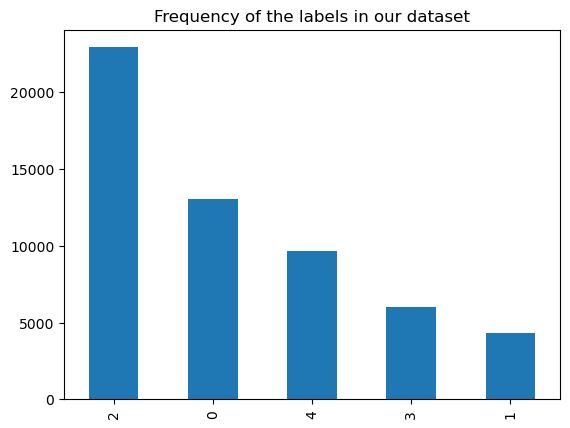

In [27]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [28]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

# X_train = np.squeeze(X_train)
# X_test = np.squeeze(X_test)
# X_val = np.squeeze(X_val)

Shape of the input data: (55989, 3000, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3000, 1)
test_dataset: (5599, 3000, 1)



In [29]:
class_weights = {0:4.0, 1:4.0, 2:1.0, 3:4.0, 4:4.0}

In [33]:
svm_wo_pca = SVC(kernel='rbf')
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to 2D
svm_wo_pca.fit(X_train_reshaped, y_train)  # Use reshaped data for training

SVC()

In [34]:

# Perform prediction on test data using the trained SVM model
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)  # Reshape test data
y_pred = svm_wo_pca.predict(X_test_reshaped)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of SVM model without PCA: {accuracy}")


Accuracy of SVM model without PCA: 0.5904625826040364


In [36]:
import pickle

# Save the model
with open('svm_model_without_pca.pkl', 'wb') as file:
    pickle.dump(svm_wo_pca, file)

# Load the model
with open('svm_model_without_pca.pkl', 'rb') as file:
    svm_wo_pca_loaded = pickle.load(file)

import os

# Check the current working directory
print(os.getcwd())



e:\project sleep analysis
